#import

In [1]:
# Importing the libs we need
import os
import cv2
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.layers import MaxPooling2D

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load database

In [3]:
LOCAL_DATABASE_PATH = "/content/drive/MyDrive/Estudos/estagio/PetImages"
CAT_IMAGES = os.path.join(LOCAL_DATABASE_PATH, 'Cat')
DOG_IMAGES = os.path.join(LOCAL_DATABASE_PATH, 'Dog')

def get_databases(img_shape=(250,250), train_size = 0.75):

  # Image shape used in this database: 128,128
  database = np.array([])
  labels = np.array([])
  qtd = 0

  # check if .npy files is already created
  if not ( os.path.isfile(os.path.join(LOCAL_DATABASE_PATH, f"database_{img_shape}.npy"))
          or os.path.isfile(os.path.join(LOCAL_DATABASE_PATH, f"labels_{img_shape}.npy")) ):
      # LOAD cat image files
      for file_ in os.listdir(CAT_IMAGES):
          im = cv2.imread(os.path.join(CAT_IMAGES, file_), cv2.IMREAD_GRAYSCALE)
          
          if im is None: continue
          im_resized = cv2.resize(im, img_shape[::-1])
          im_resized = im_resized.reshape(img_shape + (1,))

          database = np.append(database, im_resized)
          labels = np.append(labels, [1,0])

          qtd+=1
          if qtd%100 == 0:
            print(qtd)
      
      # LOAD dog image files
      for file_ in os.listdir(DOG_IMAGES):
          im = cv2.imread(os.path.join(DOG_IMAGES, file_), cv2.IMREAD_GRAYSCALE)
          
          if im is None: continue
          im_resized = cv2.resize(im, img_shape[::-1])
          im_resized = im_resized.reshape(img_shape + (1,))

          database = np.append(database, im_resized)
          labels = np.append(labels, [0,1])
          qtd+=1
          if qtd%100 == 0:
            print(qtd)

      print("[ OK ]")

      database = database.reshape((qtd,) + img_shape + (1,))
      labels = labels.reshape((qtd,2))

      if not os.path.isdir(LOCAL_DATABASE_PATH):
          os.mkdir(LOCAL_DATABASE_PATH, mode=711)

      np.save(os.path.join(LOCAL_DATABASE_PATH, f"database_{img_shape}.npy"),
              database)
      np.save(os.path.join(LOCAL_DATABASE_PATH, f"labels_{img_shape}.npy"),
              labels)
  else:
      print("Loading database from npy file...", end=' ')
      database = np.load(os.path.join(LOCAL_DATABASE_PATH, f"database_{img_shape}.npy"))
      labels = np.load(os.path.join(LOCAL_DATABASE_PATH, f"labels_{img_shape}.npy"))
      print("[ OK ]")

  x_train, x_valid, y_train, y_valid = train_test_split(database, labels, 
                                                        test_size=1 - train_size, 
                                                        shuffle= True)
  return x_train, x_valid, y_train, y_valid

"""x_train, x_valid, y_train, y_valid = get_databases(img_shape=(128,128),  train_size = 0.75)
print('x_train shape', x_train.shape)
print('y_train shape', y_train.shape)
print('x_valid shape', x_valid.shape)
print('y_valid shape', y_valid.shape)"""

"x_train, x_valid, y_train, y_valid = get_databases(img_shape=(128,128),  train_size = 0.75)\nprint('x_train shape', x_train.shape)\nprint('y_train shape', y_train.shape)\nprint('x_valid shape', x_valid.shape)\nprint('y_valid shape', y_valid.shape)"

#Models

#### model 1

In [4]:
acc_list_1 = list()
loss_list_1 = list()
num_trains = 1
img_shape = (128,128, 1)
train_size = 0.80
for i in range(num_trains):

    x_train, x_valid, y_train, y_valid = (0, 0, 0, 0)
    x_train, x_valid, y_train, y_valid = get_databases(train_size=train_size, img_shape=img_shape[0:2])

    model_1 = Sequential()

    model_1.add(Conv2D(16, kernel_size=3, name="conv1", strides=1, activation='relu', input_shape=(img_shape)))
    model_1.add(MaxPooling2D(pool_size=(2,2), name="pool1", strides=2))
    
    model_1.add(Conv2D(16, kernel_size=3,name="conv2", strides=1, activation='relu'))
    model_1.add(MaxPooling2D(pool_size=(2,2), name="pool2", strides=2))
    
    model_1.add(Conv2D(32, kernel_size=3,name="conv3", strides=1, activation='relu'))
    model_1.add(MaxPooling2D(pool_size=(2,2), name="pool3", strides=2))
    
    model_1.add(Conv2D(64, kernel_size=3, name="conv4", strides=1, activation='relu'))
    model_1.add(MaxPooling2D(pool_size=(2,2), name="pool4", strides=2))

    model_1.add(Flatten())
    model_1.add(Dense(50, activation='relu', name="dense1"))
    model_1.add(Dense(50, activation='relu', name="dense2"))
    model_1.add(Dense(50, activation='relu', name="dense3"))
    model_1.add(Dense(2, activation='softmax', name="out"))

    model_1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

    model_1.summary()

    print(f"Training Model... Round {i+1}", end='  ')
    model_1_train = model_1.fit(x_train, y_train, verbose=1, batch_size=16, epochs=50, validation_split=0.05)

    results = model_1.evaluate(x_valid, y_valid, batch_size=32, verbose=0)
    print('test loss {} - test acc: {}'.format(results[0], results[1]))
    acc_list_1.append(results[1])
    loss_list_1.append(results[0])

  
print('Testes:')
[print(acc_n) for acc_n in acc_list_1]
print(f'Média = {np.sum(acc_list_1)/len(acc_list_1)}')

Loading database from npy file... [ OK ]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 126, 126, 16)      160       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 63, 63, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 61, 61, 16)        2320      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 30, 30, 16)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 28, 28, 32)        4640      
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv4 (Conv2D) 

In [5]:
#model_1.save("/content/drive/MyDrive/Estudos/estagio/PetImages/models")

# Graphics

#### predicts

In [8]:
x_predict_model_1 = model_1.predict(x_valid)
CAT_model_1 = list()
DOG_model_1 = list()
for index, answer in enumerate(y_valid):
  #print(f'{index} -> \t\t{x_predict_model_1[index]}   \t?  \t{answer}')
  
  if answer[0] > 0.5:
    CAT_model_1.append(x_predict_model_1[index][0])
  else:
    DOG_model_1.append(x_predict_model_1[index][1])

#print(CAT_model_1)
#print(DOG_model_1)

#### Distributions

Text(0, 0.5, 'distribution of model predictions')

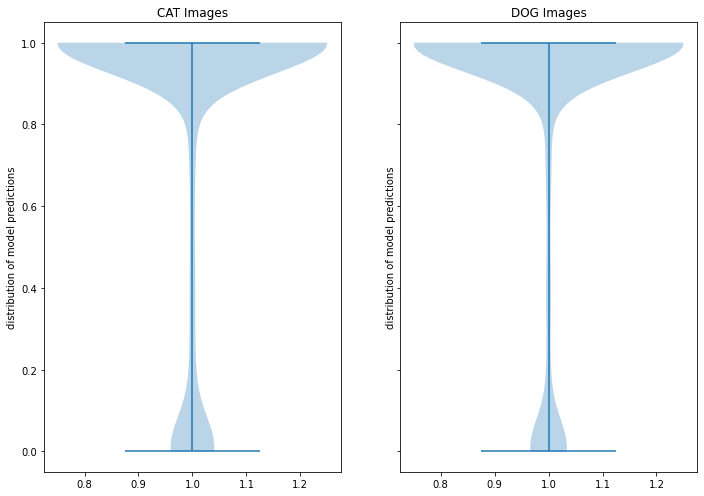

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(11.7, 8.27))

ax1.set_title('CAT Images')
ax1.violinplot(CAT_model_1)
ax1.set_ylabel("distribution of model predictions")

ax2.set_title('DOG Images')
ax2.violinplot(DOG_model_1)
ax2.set_ylabel("distribution of model predictions")